In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

# import SummaryWriter
from torch.utils.tensorboard import SummaryWriter

# import the MNIST dataset
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms

import torchsummary

from sklearn.model_selection import train_test_split

# from torchdiffeq import odeint, odeint_adjoint

import cv2
import numpy as np

from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

from tqdm.notebook import trange

from src.utils import create_gaussian_dataset, add_spatial_encoding, stack_dataset

In [38]:
# use the ball dataset

dataset = create_gaussian_dataset(r_min=3.0, r_max=3.0, n_samples=30000, size=28, margin=1, n_balls=1)
dataset = add_spatial_encoding(dataset)
# dataset = stack_dataset(dataset)

train_dataset, test_dataset = train_test_split(dataset, test_size=0.3)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [15]:
# load the moving MNIST resized dataset 
data = np.load('data/MOVING_MNIST/mnist_test_seq_resized.npy')
data = data.reshape(-1, 1, 28, 28)
data = data.astype(np.float32)
data = (data - data.min()) / (data.max() - data.min())
data = [(image, 0) for image in data]
data = add_spatial_encoding(data)


train_dataset, test_dataset = train_test_split(data, test_size=0.3)

# train_data = [(x,0) for x in train_data]
# test_data = [(x,0) for x in test_data]

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

28


In [39]:
class ConvAE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.flatten = nn.Flatten()
        self.height = kwargs['height']
        self.width = kwargs['width']
        self.latent_dim = kwargs['latent_dim']
        self.in_channels = kwargs['in_channels']

        self.encoder = nn.Sequential(
                    nn.Conv2d(in_channels=self.in_channels, out_channels=32, kernel_size=5, stride=2, padding=1),
                    nn.ReLU(),
                    # nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1),
                    nn.ReLU(),
                    # nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
                    nn.ReLU()
                    # nn.MaxPool2d(kernel_size=2, stride=2),

        )
        
        self.encoder_linear = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(in_features=3*3*128, out_features=self.latent_dim),
                    # nn.ReLU()
        )

        self.decoder_linear = nn.Sequential(
                    nn.Linear(in_features=self.latent_dim, out_features=3*3*128),
                    nn.ReLU()
        )
        self.decoder = nn.Sequential(
                    nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=0),
                    nn.ReLU(),
                    nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
                    nn.ReLU(),
                    nn.ConvTranspose2d(in_channels=32, out_channels=self.in_channels, kernel_size=4, stride=2, padding=1),
                    nn.Sigmoid()
        )

        # print the number of parameters in the model
        print("Number of parameters in the model: {}".format(np.sum([p.numel() for p in self.parameters() if p.requires_grad])))

    def forward(self, image):
        # print(image.shape)
        out = self.encoder(image)
        # print(out.shape)
        latent = self.encoder_linear(out)
        # print(latent.shape)
        out = self.decoder_linear(latent)
        # print(out.shape)
        out = out.view(image.shape[0], 128, 3, 3)
        # print(out.shape)
        out = self.decoder(out)
        # print(out.shape)
        return out

    def encode(self, image):
        out = self.encoder(image)
        out = self.encoder_linear(out)
        return out

    def decode(self, latent_vector):
        # print(latent_vector.shape)
        out = self.decoder_linear(latent_vector)
        out = out.view(out.shape[0], 128, 3, 3)
        out = self.decoder(out)
        return out

    def generate(self, n_samples=1):
        self.eval()
        with torch.no_grad():
            z = torch.randn(n_samples, self.latent_dim)
            img = self.decode(z)
            return img

    def plot(self, n_samples=1):
        self.eval()
        imgs = self.generate(n_samples)
        imgs = imgs[:,0].cpu().detach().numpy()
        imgs = np.reshape(imgs, (n_samples, 28, 28))
        fig, ax = plt.subplots(figsize=(10,5))
        for i in range(n_samples):
            plt.subplot(1, n_samples, i+1)
            plt.imshow(imgs[i], cmap='gray')
            plt.axis('off')
        plt.show()

    def reconstruction(self, plot_loader):
        self.eval()
        for i, data in enumerate(plot_loader):
            input_image, _ = data
            input_image = input_image.float()
            batch_size = input_image.shape[0]
            img = self(input_image)
            img = img[:,0].cpu().detach().numpy()
            img = np.reshape(img, (batch_size, 28, 28))
            input_image = input_image[:,0].cpu().detach().numpy()
            input_image = np.reshape(input_image, (batch_size, 28, 28))

            fig, ax = plt.subplots(figsize=(20,2))
            for i in range(batch_size):
                plt.subplot(2, batch_size, i+1)
                plt.imshow(img[i], cmap='gray')
                plt.axis('off')
                
            for i in range(batch_size):
                plt.subplot(2, batch_size, i+1+batch_size)
                plt.imshow(input_image[i], cmap='gray')
                plt.axis('off')
            plt.show()
            break

    def fit(self, dataloader_train, dataloader_test, optimizer, scheduler, criterion, epochs=10, display_step=1, n_plot=10):
        iterator = trange(epochs)
        losses_train = []
        losses_test = []
        for _ in iterator:
            self.plot(n_samples=n_plot)
            self.reconstruction(dataloader_test)
            
            loss_epoch = 0
            self.train()
            for i, data in enumerate(dataloader_train):
                input_image, _ = data
                input_image = input_image.float()
                optimizer.zero_grad()
                img = self(input_image)
                loss = criterion(input_image, img)
                loss.backward()
                optimizer.step()
                loss_epoch += loss.item()
                if i % display_step == 0:
                    iterator.set_description(f'Batch: {i}/{len(dataloader_train)}, Loss: {loss_epoch/(i+1):.6f}')
                

            losses_train.append(loss_epoch/len(dataloader_train))
            # self.eval()
            # with torch.no_grad():
            #     loss_epoch = 0
            #     for i, data in enumerate(dataloader_test):
            #         input_image, _ = data
            #         input_image = input_image.float()
            #         img = self(input_image)
            #         loss = criterion(input_image, img)
            #         loss_epoch += loss.item()
            #         if i % display_step == 0:
            #             iterator.set_postfix_str(f'Test Batch: {i}/{len(dataloader_test)}, Loss: {loss_epoch/(i+1):.6f}')

            #     losses_test.append(loss_epoch/len(dataloader_test))
            
            scheduler.step()

        return losses_train, losses_test


class custom_loss(nn.Module):
    def __init__(self):
        super(custom_loss, self).__init__()
    
    def forward(self, x, dec):
        # dec = dec[:,0]
        # x = x[:,0]
        unreshaped = torch.reshape(dec, [-1, 28*28])
        x = torch.reshape(x, [-1, 28*28])
        # print(unreshaped.shape)
        img_loss = torch.mean(torch.sum((unreshaped - x)**2, dim=1))
        # print(img_loss.shape)
        loss = torch.mean(img_loss)
        # print(loss.shape)
        return loss

loss_fn = custom_loss()

In [40]:
class ConvAEwithResNet(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.flatten = nn.Flatten()
        self.height = kwargs['height']
        self.width = kwargs['width']
        self.latent_dim = kwargs['latent_dim']

        self.encoder = nn.Sequential(*list(torchvision.models.resnet18(pretrained=True).children())[:-1], 
                                            nn.Flatten())
        self.encoder_linear = nn.Linear(512, self.latent_dim)

        self.decoder_linear = nn.Sequential(
                    nn.Linear(in_features=self.latent_dim, out_features=3*3*128),
                    nn.ReLU()
        )
        self.decoder = nn.Sequential(
                    nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=0),
                    nn.ReLU(),
                    nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
                    nn.ReLU(),
                    nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=4, stride=2, padding=1),
                    nn.Sigmoid()
        )

        # print the number of parameters in the model
        print("Number of parameters in the model: {}".format(np.sum([p.numel() for p in self.parameters() if p.requires_grad])))

    def forward(self, image):
        # print(image.shape)
        out = self.encoder(image)
        # print(out.shape)
        latent = self.encoder_linear(out)
        # print(latent.shape)
        out = self.decoder_linear(latent)
        # print(out.shape)
        out = out.view(image.shape[0], 128, 3, 3)
        # print(out.shape)
        out = self.decoder(out)
        # print(out.shape)
        return out

    def encode(self, image):
        out = self.encoder(image)
        out = self.encoder_linear(out)
        return out

    def decode(self, latent_vector):
        # print(latent_vector.shape)
        out = self.decoder_linear(latent_vector)
        out = out.view(out.shape[0], 128, 3, 3)
        out = self.decoder(out)
        return out

    def generate(self, n_samples=1):
        self.eval()
        with torch.no_grad():
            z = torch.randn(n_samples, self.latent_dim)
            img = self.decode(z)
            return img

    def plot(self, n_samples=1):
        self.eval()
        imgs = self.generate(n_samples)
        imgs = imgs[:,0].cpu().detach().numpy()
        imgs = np.reshape(imgs, (n_samples, 28, 28))
        fig, ax = plt.subplots(figsize=(10,5))
        for i in range(n_samples):
            plt.subplot(1, n_samples, i+1)
            plt.imshow(imgs[i], cmap='gray')
            plt.axis('off')
        plt.show()

    def reconstruction(self, plot_loader):
        self.eval()
        for i, data in enumerate(plot_loader):
            input_image, _ = data
            input_image = input_image.float()
            batch_size = input_image.shape[0]
            img = self(input_image)
            img = img[:,0].cpu().detach().numpy()
            img = np.reshape(img, (batch_size, 28, 28))
            input_image = input_image[:,0].cpu().detach().numpy()
            input_image = np.reshape(input_image, (batch_size, 28, 28))

            N_samples_recon = batch_size
            
            height_plot = 15
            width_plot = height_plot * int(np.ceil(N_samples_recon/2))
            fig, ax = plt.subplots(figsize=(width_plot,height_plot))
            for i in range(batch_size):
                plt.subplot(2, batch_size, i+1)
                plt.imshow(img[i], cmap='gray')
                plt.axis('off')
                
            for i in range(batch_size):
                plt.subplot(2, batch_size, i+1+batch_size)
                plt.imshow(input_image[i], cmap='gray')
                plt.axis('off')
            plt.show()
            break

    def fit(self, dataloader_train, dataloader_test, optimizer, scheduler, criterion, epochs=10, display_step=1, n_plot=10):
        iterator = trange(epochs)
        losses_train = []
        losses_test = []
        for _ in iterator:
            self.plot(n_samples=n_plot)
            self.reconstruction(dataloader_test)
            
            loss_epoch = 0
            self.train()
            for i, data in enumerate(dataloader_train):
                input_image, _ = data
                input_image = input_image.float()
                optimizer.zero_grad()
                img = self(input_image)
                loss = criterion(input_image, img)
                loss.backward()
                optimizer.step()
                loss_epoch += loss.item()
                if i % display_step == 0:
                    iterator.set_description(f'Batch: {i}/{len(dataloader_train)}, Loss: {loss_epoch/(i+1):.6f}')
                

            losses_train.append(loss_epoch/len(dataloader_train))
            # self.eval()
            # with torch.no_grad():
            #     loss_epoch = 0
            #     for i, data in enumerate(dataloader_test):
            #         input_image, _ = data
            #         input_image = input_image.float()
            #         img = self(input_image)
            #         loss = criterion(input_image, img)
            #         loss_epoch += loss.item()
            #         if i % display_step == 0:
            #             iterator.set_postfix_str(f'Test Batch: {i}/{len(dataloader_test)}, Loss: {loss_epoch/(i+1):.6f}')

            #     losses_test.append(loss_epoch/len(dataloader_test))
            
            scheduler.step()

        return losses_train, losses_test

In [41]:
ae = ConvAE(height=28, width=28, latent_dim=2, in_channels=3)

Number of parameters in the model: 220387


In [44]:
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-2)
# optimizer = torch.optim.RMSprop(vae.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9999)

  0%|          | 0/100 [00:00<?, ?it/s]

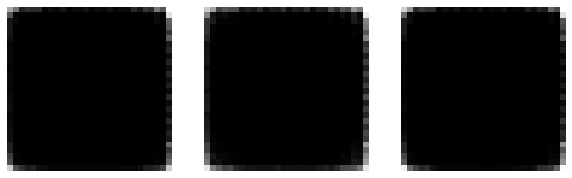

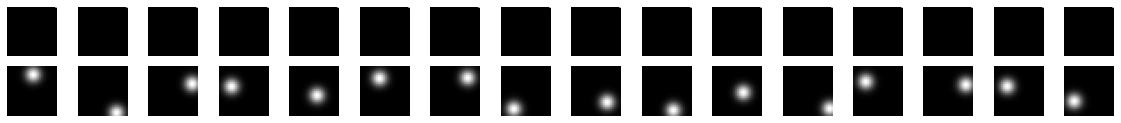

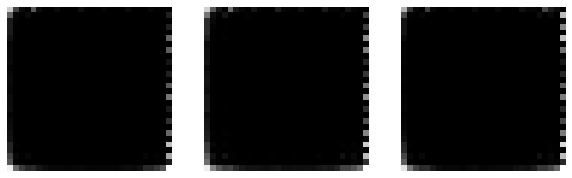

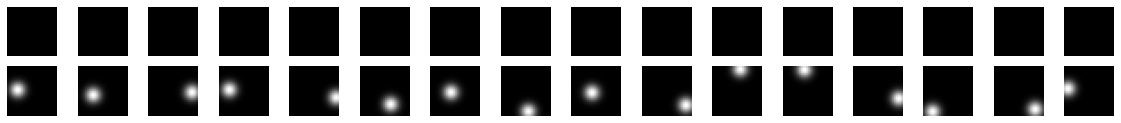

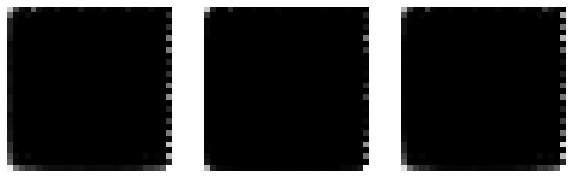

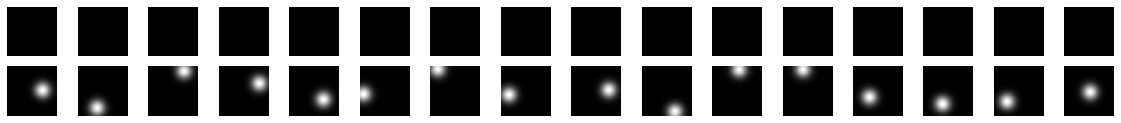

KeyboardInterrupt: 

In [45]:
ae.fit(train_loader, test_loader, optimizer, scheduler, loss_fn, epochs=100, display_step=1, n_plot=3)

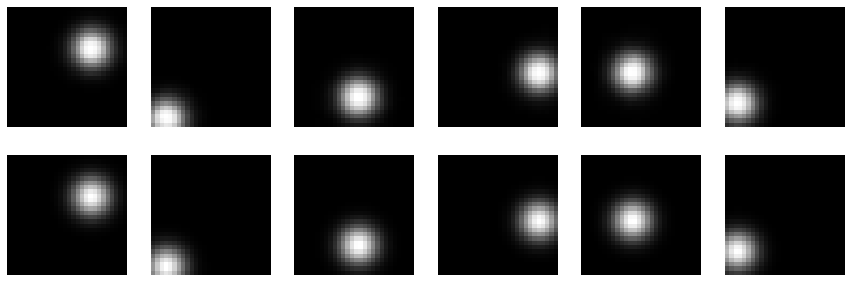

In [35]:
# use the VAE to reconstruct images and there initial images
N_samples_recon = 6
plot_loader = DataLoader(test_dataset, batch_size=N_samples_recon)
ae.eval()
with torch.no_grad():
    limit = np.random.randint(0, int(len(test_dataset)/N_samples_recon))
    for i, data in enumerate(plot_loader):
        if i <= limit:
            continue
        input_image, _ = data
        input_image = input_image.float()
        img = ae(input_image)
        img = img[:,0].cpu().detach().numpy()
        img = np.reshape(img, (N_samples_recon, 28, 28))
        input_image = input_image[:,0].cpu().detach().numpy()
        input_image = np.reshape(input_image, (N_samples_recon, 28, 28))
        height_plot = 5 
        width_plot = height_plot * int(np.ceil(N_samples_recon/2))
        fig, ax = plt.subplots(figsize=(width_plot,height_plot))
        for i in range(N_samples_recon):
            plt.subplot(2, N_samples_recon, i+1)
            plt.imshow(img[i], cmap='gray')
            plt.axis('off')
            
        for i in range(N_samples_recon):
            plt.subplot(2, N_samples_recon, i+1+N_samples_recon)
            plt.imshow(input_image[i], cmap='gray')
            plt.axis('off')
        plt.show()
        break



In [36]:
torch.save(ae.state_dict(), 'models/AE/ae_1_Ball_with_sp_latent_2_no_relu.pth')